In [1]:
 !pip install numpy scipy scikit-learn matplotlib deap


[notice] A new release of pip available: 22.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip



# ##  Imports and Configuration

In [2]:
import numpy as np
import random
import re
import copy
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from scipy.stats import entropy, mannwhitneyu, kruskal
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import warnings
import time
from datetime import datetime

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("="*70)
print(" GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON")
print(" Using GRAPE (Grammatical Algorithms in Python for Evolution)")
print("="*70)
print(f"Experiment date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

 GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON
 Using GRAPE (Grammatical Algorithms in Python for Evolution)
Experiment date: 2026-02-04 19:38


### GRAPE Library Implementation
### This section contains the core GRAPE library classes and functions for Grammatical Evolution.


In [3]:
# =============================================================================
# GRAPE: Grammatical Algorithms in Python for Evolution
# =============================================================================

class Grammar:
    """
    A class to represent a BNF grammar for Grammatical Evolution.
    """
    
    def __init__(self, bnf_grammar):
        self.rules = OrderedDict()
        self.start_symbol = None
        self.non_terminals = []
        self.terminals = set()
        self.min_depth = {}
        self.recursive_rules = {}
        self.non_recursive_rules = {}
        
        self._parse_grammar(bnf_grammar)
        self._compute_depths()
        self._classify_rules()
    
    def _parse_grammar(self, bnf_grammar):
        """Parse BNF grammar string into internal representation."""
        lines = [line.strip() for line in bnf_grammar.split('\n') 
                 if line.strip() and not line.strip().startswith('#')]
        grammar_text = ' '.join(lines)
        
        rule_pattern = r'<(\w+)>\s*::=\s*([^<]*(?:<\w+>[^<]*)*?)(?=\s*<\w+>\s*::=|$)'
        matches = re.findall(rule_pattern, grammar_text + ' ')
        
        for nt, productions in matches:
            nt_symbol = f'<{nt}>'
            if self.start_symbol is None:
                self.start_symbol = nt_symbol
            
            self.non_terminals.append(nt_symbol)
            prods = [p.strip() for p in productions.split('|') if p.strip()]
            self.rules[nt_symbol] = []
            
            for prod in prods:
                tokens = self._tokenize(prod)
                self.rules[nt_symbol].append(tokens)
                for token in tokens:
                    if not self._is_non_terminal(token):
                        self.terminals.add(token)
    
    def _tokenize(self, production):
        tokens = []
        pattern = r'(<\w+>|[^\s<>]+)'
        for match in re.findall(pattern, production):
            if match:
                tokens.append(match)
        return tokens
    
    def _is_non_terminal(self, symbol):
        return symbol.startswith('<') and symbol.endswith('>')
    
    def _compute_depths(self):
        for nt in self.non_terminals:
            self.min_depth[nt] = float('inf')
        
        changed = True
        while changed:
            changed = False
            for nt in self.non_terminals:
                for prod in self.rules[nt]:
                    prod_depth = 0
                    for symbol in prod:
                        if self._is_non_terminal(symbol) and symbol in self.min_depth:
                            prod_depth = max(prod_depth, self.min_depth[symbol] + 1)
                        elif self._is_non_terminal(symbol):
                            prod_depth = float('inf')
                    
                    if prod_depth == 0:
                        prod_depth = 1
                    
                    if prod_depth < self.min_depth[nt]:
                        self.min_depth[nt] = prod_depth
                        changed = True
    
    def _classify_rules(self):
        for nt in self.non_terminals:
            self.recursive_rules[nt] = []
            self.non_recursive_rules[nt] = []
            
            for i, prod in enumerate(self.rules[nt]):
                is_recursive = any(self._is_non_terminal(s) and s in self.non_terminals 
                                   for s in prod)
                if is_recursive:
                    self.recursive_rules[nt].append(i)
                else:
                    self.non_recursive_rules[nt].append(i)
    
    def get_production(self, non_terminal, codon):
        productions = self.rules[non_terminal]
        return productions[codon % len(productions)]
    
    def n_productions(self, non_terminal):
        return len(self.rules[non_terminal])


class Individual:
    """Individual class for Grammatical Evolution."""
    
    def __init__(self, genome=None):
        self.genome = genome if genome is not None else []
        self.phenotype = None
        self.fitness = None
        self.invalid = True
        self.depth = 0
        self.used_codons = 0
        self.nodes = 0
    
    def __len__(self):
        return len(self.genome)
    
    def copy(self):
        new_ind = Individual(genome=self.genome.copy())
        new_ind.phenotype = self.phenotype
        new_ind.fitness = self.fitness
        new_ind.invalid = self.invalid
        new_ind.depth = self.depth
        new_ind.used_codons = self.used_codons
        new_ind.nodes = self.nodes
        return new_ind


def mapper(individual, grammar, max_wraps=2, max_depth=50):
    """Map a genome to a phenotype using the grammar."""
    genome = individual.genome
    if not genome:
        individual.invalid = True
        return individual
    
    output = []
    stack = [(grammar.start_symbol, 0)]
    codon_idx = 0
    wraps = 0
    max_depth_reached = 0
    nodes = 0
    
    while stack:
        symbol, depth = stack.pop()
        max_depth_reached = max(max_depth_reached, depth)
        
        if depth > max_depth:
            individual.invalid = True
            return individual
        
        if grammar._is_non_terminal(symbol):
            if symbol not in grammar.rules:
                output.append(symbol)
                continue
            
            nodes += 1
            
            if codon_idx >= len(genome):
                wraps += 1
                codon_idx = 0
                if wraps > max_wraps:
                    individual.invalid = True
                    return individual
            
            codon = genome[codon_idx]
            codon_idx += 1
            production = grammar.get_production(symbol, codon)
            
            for s in reversed(production):
                stack.append((s, depth + 1))
        else:
            output.append(symbol)
    
    individual.phenotype = ''.join(output)
    individual.invalid = False
    individual.depth = max_depth_reached
    individual.used_codons = codon_idx
    individual.nodes = nodes
    
    return individual


def random_initialisation(ind_class, genome_length, codon_size=256):
    """Create a random individual."""
    genome = [random.randint(0, codon_size - 1) for _ in range(genome_length)]
    return ind_class(genome=genome)


def sensible_initialisation(ind_class, grammar, min_init_depth=2, max_init_depth=6, 
                            codon_size=256, genome_length=100, method='grow'):
    """Create an individual using sensible initialisation (Ramped Half-and-Half for GE)."""
    target_depth = random.randint(min_init_depth, max_init_depth)
    
    if method == 'rhh':
        method = random.choice(['grow', 'full'])
    
    genome = []
    stack = [(grammar.start_symbol, 0)]
    
    while stack:
        symbol, depth = stack.pop(0)
        
        if not grammar._is_non_terminal(symbol) or symbol not in grammar.rules:
            continue
        
        productions = grammar.rules[symbol]
        n_prods = len(productions)
        
        if method == 'full':
            if depth < target_depth - 1 and grammar.recursive_rules[symbol]:
                valid_indices = grammar.recursive_rules[symbol]
            else:
                valid_indices = grammar.non_recursive_rules[symbol] if grammar.non_recursive_rules[symbol] else list(range(n_prods))
        else:
            if depth >= target_depth - 1 and grammar.non_recursive_rules[symbol]:
                valid_indices = grammar.non_recursive_rules[symbol]
            else:
                valid_indices = list(range(n_prods))
        
        selected_idx = random.choice(valid_indices)
        
        base = selected_idx
        max_k = (codon_size - 1 - base) // n_prods if n_prods > 0 else 0
        k = random.randint(0, max(0, max_k))
        codon = base + k * n_prods
        genome.append(codon)
        
        production = productions[selected_idx]
        for s in production:
            if grammar._is_non_terminal(s):
                stack.append((s, depth + 1))
    
    while len(genome) < genome_length:
        genome.append(random.randint(0, codon_size - 1))
    
    return ind_class(genome=genome[:genome_length])


def crossover_onepoint(ind1, ind2):
    """Execute one-point crossover on the genomes."""
    size = min(len(ind1.genome), len(ind2.genome))
    if size <= 1:
        return ind1.copy(), ind2.copy()
    
    cxpoint = random.randint(1, size - 1)
    
    child1 = ind1.copy()
    child2 = ind2.copy()
    
    child1.genome = ind1.genome[:cxpoint] + ind2.genome[cxpoint:]
    child2.genome = ind2.genome[:cxpoint] + ind1.genome[cxpoint:]
    
    child1.phenotype = None
    child1.invalid = True
    child1.fitness = None
    child2.phenotype = None
    child2.invalid = True
    child2.fitness = None
    
    return child1, child2


def mutation_int_flip_per_codon(individual, mutation_rate=0.01, codon_size=256):
    """Mutate an individual by randomly changing codons."""
    mutant = individual.copy()
    
    for i in range(len(mutant.genome)):
        if random.random() < mutation_rate:
            mutant.genome[i] = random.randint(0, codon_size - 1)
    
    mutant.phenotype = None
    mutant.invalid = True
    mutant.fitness = None
    
    return mutant


def tournament_selection(population, k, tournsize):
    """Select k individuals using tournament selection."""
    selected = []
    for _ in range(k):
        aspirants = random.sample(population, min(tournsize, len(population)))
        winner = min(aspirants, key=lambda x: x.fitness if x.fitness is not None else float('inf'))
        selected.append(winner.copy())
    return selected

print("GRAPE library loaded successfully!")



GRAPE library loaded successfully!



# ## Experimental Configuration


In [4]:

# %%
# Experimental parameters
N_RUNS = 30
GENERATIONS = 50
POP_SIZE = 100
ELITE_SIZE = 5
GENOME_LENGTH = 100
MAX_DEPTH = 17
MAX_WRAPS = 2
CODON_SIZE = 256
TOURNAMENT_SIZE = 3
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.01

print("Experimental Parameters:")
print(f"  Runs: {N_RUNS}, Generations: {GENERATIONS}, Population: {POP_SIZE}")
print(f"  Genome Length: {GENOME_LENGTH}, Max Depth: {MAX_DEPTH}, Max Wraps: {MAX_WRAPS}")
print(f"  Crossover: {CROSSOVER_RATE}, Mutation: {MUTATION_RATE}")

# Plotting configuration
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

COLORS = {'Random': '#E74C3C', 'Sensible': '#3498DB'}
MARKERS = {'Random': 'o', 'Sensible': 's'}

# %% [markdown]
# ## 5. Benchmark Problems

# %%
def load_diabetes_problem():
    """Sklearn Diabetes dataset - multivariate regression."""
    diabetes = load_diabetes()
    X, y = diabetes.data, diabetes.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    return {
        'name': 'Diabetes',
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'n_features': 10,
        'multivariate': True,
        'description': 'Scikit-learn benchmark (10 features)'
    }


def keijzer_6(x):
    """Keijzer-6: Harmonic series H_n = sum(1/i for i=1..n)"""
    return np.array([sum(1.0/i for i in range(1, int(xi)+1)) for xi in x])


def load_keijzer6_problem():
    """Keijzer-6 benchmark problem."""
    X_train = np.linspace(1, 50, 50).reshape(-1, 1)
    y_train = keijzer_6(X_train.flatten())
    X_test = np.linspace(1, 120, 120).reshape(-1, 1)
    y_test = keijzer_6(X_test.flatten())
    return {
        'name': 'Keijzer-6',
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'n_features': 1,
        'multivariate': False,
        'description': 'Harmonic series: H_n = sum(1/i)'
    }


def nguyen_7(x):
    """Nguyen-7: f(x) = ln(x+1) + ln(x^2+1)"""
    return np.log(x + 1) + np.log(x**2 + 1)


def load_nguyen7_problem():
    """Nguyen-7 benchmark problem."""
    X_train = np.linspace(0, 2, 20).reshape(-1, 1)
    y_train = nguyen_7(X_train.flatten())
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    y_test = nguyen_7(X_test.flatten())
    return {
        'name': 'Nguyen-7',
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'n_features': 1,
        'multivariate': False,
        'description': 'f(x) = ln(x+1) + ln(x²+1)'
    }


def pagie_1(X):
    """Pagie-1: f(x,y) = 1/(1+x^-4) + 1/(1+y^-4)"""
    x, y = X[:, 0], X[:, 1]
    with np.errstate(divide='ignore', invalid='ignore'):
        result = 1.0 / (1.0 + np.power(x, -4)) + 1.0 / (1.0 + np.power(y, -4))
        return np.nan_to_num(result, nan=0.0, posinf=2.0, neginf=0.0)


def load_pagie1_problem():
    """Pagie-1 2D benchmark problem."""
    x_vals = np.arange(-5, 5.01, 0.4)
    y_vals = np.arange(-5, 5.01, 0.4)
    xx, yy = np.meshgrid(x_vals, y_vals)
    X_train = np.column_stack([xx.ravel(), yy.ravel()])
    y_train = pagie_1(X_train)
    
    x_test = np.arange(-5, 5.01, 0.2)
    y_test_vals = np.arange(-5, 5.01, 0.2)
    xx_t, yy_t = np.meshgrid(x_test, y_test_vals)
    X_test = np.column_stack([xx_t.ravel(), yy_t.ravel()])
    y_test = pagie_1(X_test)
    
    return {
        'name': 'Pagie-1',
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'n_features': 2,
        'multivariate': True,
        'description': 'f(x,y) = 1/(1+x⁻⁴) + 1/(1+y⁻⁴)'
    }


# Load all problems
PROBLEMS = {
    'Diabetes': load_diabetes_problem(),
    'Keijzer-6': load_keijzer6_problem(),
    'Nguyen-7': load_nguyen7_problem(),
    'Pagie-1': load_pagie1_problem()
}

print("\nBenchmark Problems Loaded:")
for name, prob in PROBLEMS.items():
    print(f"  {name}: {prob['description']}")
    print(f"    Train: {len(prob['y_train'])}, Test: {len(prob['y_test'])} samples")

Experimental Parameters:
  Runs: 30, Generations: 50, Population: 100
  Genome Length: 100, Max Depth: 17, Max Wraps: 2
  Crossover: 0.9, Mutation: 0.01

Benchmark Problems Loaded:
  Diabetes: Scikit-learn benchmark (10 features)
    Train: 309, Test: 133 samples
  Keijzer-6: Harmonic series: H_n = sum(1/i)
    Train: 50, Test: 120 samples
  Nguyen-7: f(x) = ln(x+1) + ln(x²+1)
    Train: 20, Test: 100 samples
  Pagie-1: f(x,y) = 1/(1+x⁻⁴) + 1/(1+y⁻⁴)
    Train: 676, Test: 2601 samples


### Visualize Benchmark Problems

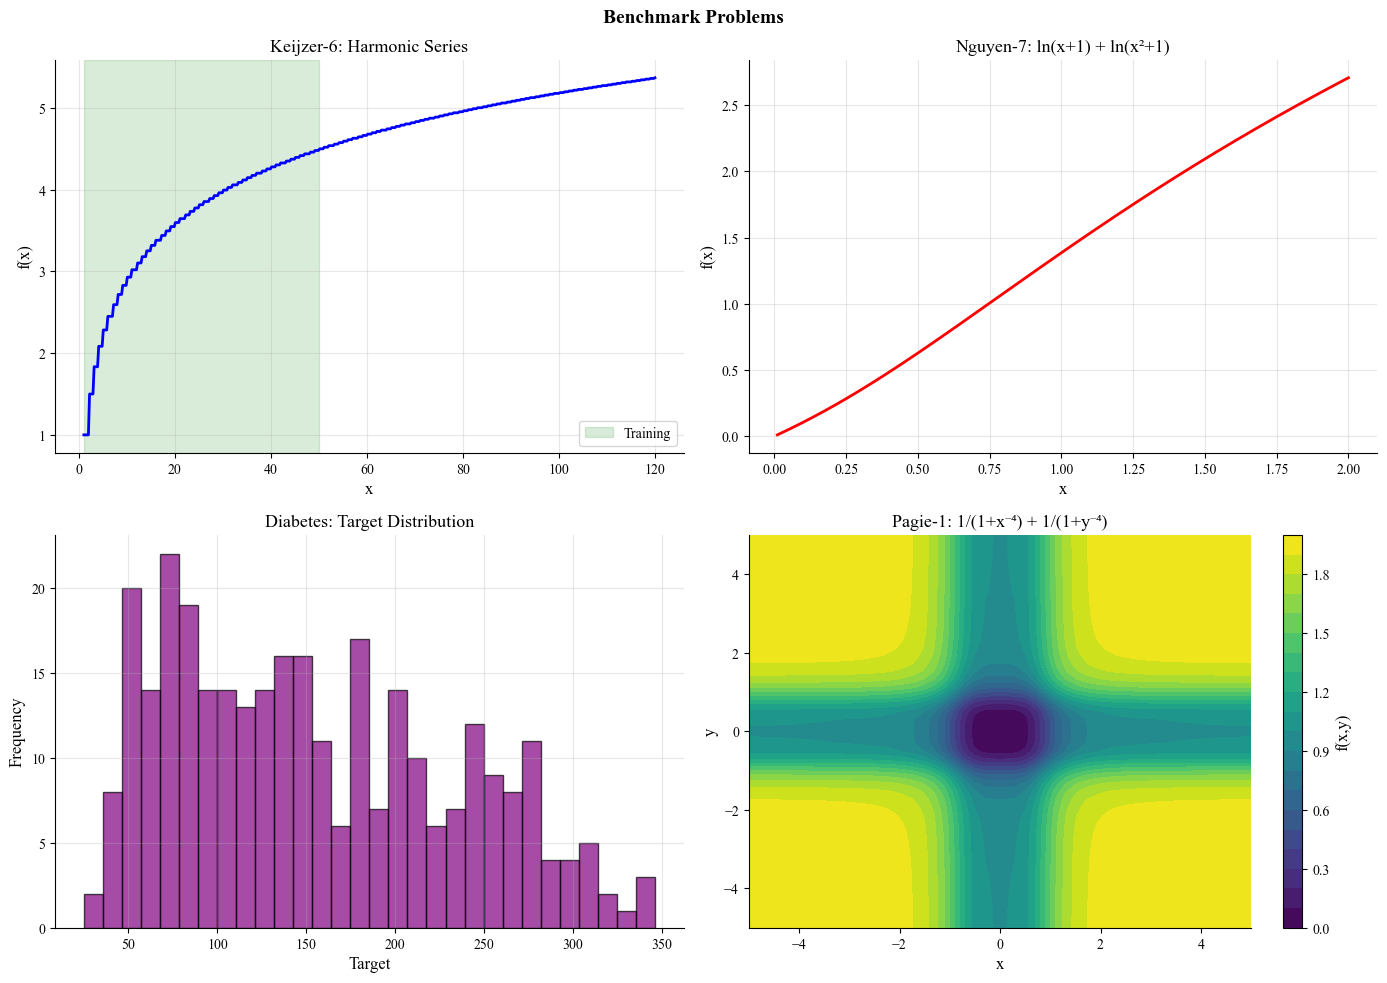

In [5]:
# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Benchmark Problems', fontsize=14, fontweight='bold')

# Keijzer-6
ax = axes[0, 0]
x_plot = np.linspace(1, 120, 500)
ax.plot(x_plot, keijzer_6(x_plot), 'b-', linewidth=2)
ax.axvspan(1, 50, alpha=0.15, color='green', label='Training')
ax.set_xlabel('x'); ax.set_ylabel('f(x)'); ax.set_title('Keijzer-6: Harmonic Series')
ax.legend(); ax.grid(True, alpha=0.3)

# Nguyen-7
ax = axes[0, 1]
x_plot = np.linspace(0.01, 2, 200)
ax.plot(x_plot, nguyen_7(x_plot), 'r-', linewidth=2)
ax.set_xlabel('x'); ax.set_ylabel('f(x)'); ax.set_title('Nguyen-7: ln(x+1) + ln(x²+1)')
ax.grid(True, alpha=0.3)

# Diabetes
ax = axes[1, 0]
ax.hist(PROBLEMS['Diabetes']['y_train'], bins=30, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('Target'); ax.set_ylabel('Frequency'); ax.set_title('Diabetes: Target Distribution')
ax.grid(True, alpha=0.3)

# Pagie-1
ax = axes[1, 1]
x_vals = np.linspace(-5, 5, 50)
y_vals = np.linspace(-5, 5, 50)
xx, yy = np.meshgrid(x_vals, y_vals)
X_grid = np.column_stack([xx.ravel(), yy.ravel()])
zz = pagie_1(X_grid).reshape(xx.shape)
c = ax.contourf(xx, yy, zz, levels=20, cmap='viridis')
plt.colorbar(c, ax=ax, label='f(x,y)')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_title('Pagie-1: 1/(1+x⁻⁴) + 1/(1+y⁻⁴)')

plt.tight_layout()
plt.show()

### Grammar Definitions and Fitness Evaluation

In [6]:
# %%
def create_grammar_multivariate(n_features):
    """Create BNF grammar for multivariate symbolic regression."""
    var_rules = ' | '.join([f'x{i}' for i in range(n_features)])
    bnf = f"""
    <expr> ::= ( <expr> <op> <expr> ) | <pre_op> ( <expr> ) | <var> | <const>
    <op> ::= + | - | * | pdiv
    <pre_op> ::= np.sin | np.cos | np.log1p | np.sqrt | np.abs
    <var> ::= {var_rules}
    <const> ::= 1.0 | 2.0 | 0.5 | 0.1 | 3.14159 | 2.71828
    """
    return Grammar(bnf)


def create_grammar_univariate():
    """Create BNF grammar for univariate symbolic regression."""
    bnf = """
    <expr> ::= ( <expr> <op> <expr> ) | <func> ( <expr> ) | <var> | <const>
    <op> ::= + | - | * | pdiv
    <func> ::= np.log | np.sqrt | np.sin | np.cos | np.abs
    <var> ::= x
    <const> ::= 1.0 | 2.0 | 0.5 | 0.1 | 2.71828 | 3.14159
    """
    return Grammar(bnf)


def get_grammar_for_problem(problem):
    """Get appropriate grammar for a problem."""
    if problem['multivariate']:
        return create_grammar_multivariate(problem['n_features'])
    return create_grammar_univariate()


def pdiv(a, b):
    """Protected division."""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(b) > 1e-10, a / b, 1.0)
        return np.nan_to_num(result, nan=1.0, posinf=1e10, neginf=-1e10)


class FitnessEvaluator:
    """Evaluator for symbolic regression fitness."""
    
    def __init__(self, X, y, multivariate=False, n_features=1):
        self.X = X
        self.y = y
        self.multivariate = multivariate
        self.n_features = n_features
        self.cache = {}
        self.eval_context = {'np': np, 'pdiv': pdiv, '__builtins__': {}}
    
    def evaluate(self, individual):
        """Evaluate an individual, returning RMSE fitness."""
        if individual.invalid or individual.phenotype is None:
            return float('inf')
        
        phenotype = individual.phenotype
        if phenotype in self.cache:
            return self.cache[phenotype]
        
        try:
            if self.multivariate:
                local_context = {f'x{i}': self.X[:, i] for i in range(self.n_features)}
            else:
                local_context = {'x': self.X.flatten()}
            
            pred = eval(phenotype, self.eval_context, local_context)
            
            if np.isscalar(pred):
                pred = np.full_like(self.y, pred)
            
            pred = np.asarray(pred).flatten()
            if len(pred) != len(self.y):
                return float('inf')
            
            pred = np.nan_to_num(np.clip(pred, -1e10, 1e10), nan=1e10, posinf=1e10, neginf=-1e10)
            rmse = np.sqrt(np.mean((pred - self.y) ** 2))
            fitness = min(rmse, 1e10)
            
            self.cache[phenotype] = fitness
            return fitness
            
        except Exception:
            self.cache[phenotype] = float('inf')
            return float('inf')

print("Grammar and fitness evaluation functions loaded!")

Grammar and fitness evaluation functions loaded!


### Evolutionary Algorithm

In [7]:
# %%
def run_evolution(init_method, grammar, problem, run_seed):
    """Run a single evolutionary experiment."""
    random.seed(run_seed)
    np.random.seed(run_seed)
    
    evaluator = FitnessEvaluator(
        problem['X_train'], problem['y_train'],
        problem['multivariate'], problem['n_features']
    )
    
    # Initialize population
    if init_method == 'Random':
        population = [
            random_initialisation(Individual, GENOME_LENGTH, CODON_SIZE)
            for _ in range(POP_SIZE)
        ]
    else:  # Sensible
        population = [
            sensible_initialisation(
                Individual, grammar,
                min_init_depth=2, max_init_depth=6,
                codon_size=CODON_SIZE, genome_length=GENOME_LENGTH,
                method='rhh'
            )
            for _ in range(POP_SIZE)
        ]
    
    # Map and evaluate initial population
    for ind in population:
        mapper(ind, grammar, MAX_WRAPS, MAX_DEPTH)
        ind.fitness = evaluator.evaluate(ind) if not ind.invalid else float('inf')
    
    # History tracking
    history = {
        'best_fitness': [], 'mean_fitness': [],
        'validity_rate': [], 'diversity': [], 'best_phenotype': []
    }
    
    # Evolution loop
    for gen in range(GENERATIONS):
        population.sort(key=lambda x: x.fitness if x.fitness is not None else float('inf'))
        
        valid_pop = [ind for ind in population if not ind.invalid and ind.fitness < 1e10]
        
        history['best_fitness'].append(population[0].fitness)
        history['mean_fitness'].append(np.mean([ind.fitness for ind in valid_pop]) if valid_pop else 1e10)
        history['validity_rate'].append(len(valid_pop) / POP_SIZE)
        history['best_phenotype'].append(population[0].phenotype)
        
        phenotypes = [ind.phenotype for ind in valid_pop if ind.phenotype]
        history['diversity'].append(entropy(list(Counter(phenotypes).values())) if phenotypes else 0)
        
        # Selection
        elite = [ind.copy() for ind in population[:ELITE_SIZE]]
        offspring = tournament_selection(population, POP_SIZE - ELITE_SIZE, TOURNAMENT_SIZE)
        
        # Crossover
        for i in range(0, len(offspring) - 1, 2):
            if random.random() < CROSSOVER_RATE:
                offspring[i], offspring[i+1] = crossover_onepoint(offspring[i], offspring[i+1])
        
        # Mutation
        for i in range(len(offspring)):
            offspring[i] = mutation_int_flip_per_codon(offspring[i], MUTATION_RATE, CODON_SIZE)
        
        # Evaluate offspring
        for ind in offspring:
            mapper(ind, grammar, MAX_WRAPS, MAX_DEPTH)
            ind.fitness = evaluator.evaluate(ind) if not ind.invalid else float('inf')
        
        population = elite + offspring
    
    # Final evaluation
    population.sort(key=lambda x: x.fitness if x.fitness is not None else float('inf'))
    
    test_evaluator = FitnessEvaluator(
        problem['X_test'], problem['y_test'],
        problem['multivariate'], problem['n_features']
    )
    test_rmse = test_evaluator.evaluate(population[0])
    
    return {'history': history, 'best_individual': population[0], 'test_rmse': test_rmse}

print("Evolutionary algorithm loaded!")

Evolutionary algorithm loaded!


### Run the Full Experiment

In [8]:
# %%
print("\n" + "="*70)
print(" RUNNING EXPERIMENT: 4 Problems x 2 Methods x 30 Runs")
print("="*70)

all_results = {}
total_start = time.time()

for prob_name, problem in PROBLEMS.items():
    print(f"\n{'#'*60}")
    print(f"# PROBLEM: {prob_name}")
    print(f"{'#'*60}")
    
    grammar = get_grammar_for_problem(problem)
    problem_results = {}
    
    for method_name in ['Random', 'Sensible']:
        print(f"\n  Running {method_name}...", end=" ")
        method_runs = []
        
        for run in range(N_RUNS):
            run_result = run_evolution(method_name, grammar, problem, SEED + run)
            method_runs.append(run_result)
            if (run + 1) % 10 == 0:
                print(f"{run + 1}", end=" ")
        
        problem_results[method_name] = method_runs
        print("Done!")
    
    all_results[prob_name] = problem_results

elapsed = (time.time() - total_start) / 60
print(f"\n{'='*70}")
print(f" Completed in {elapsed:.2f} minutes")
print(f"{'='*70}")


 RUNNING EXPERIMENT: 4 Problems x 2 Methods x 30 Runs

############################################################
# PROBLEM: Diabetes
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

############################################################
# PROBLEM: Keijzer-6
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

############################################################
# PROBLEM: Nguyen-7
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

############################################################
# PROBLEM: Pagie-1
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

 Completed in 0.52 minutes


### Statistical Analysis

In [10]:

# %%
def analyze_results(results, problem_name):
    """Perform statistical analysis on results."""
    print(f"\n{'='*70}")
    print(f" STATISTICAL ANALYSIS: {problem_name}")
    print(f"{'='*70}")
    
    methods = list(results.keys())
    
    final_fitness = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    test_fitness = {m: [r['test_rmse'] for r in results[m]] for m in methods}
    init_validity = {m: [r['history']['validity_rate'][0] for r in results[m]] for m in methods}
    
    print("\n1. Training RMSE Summary")
    print("-" * 65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 65)
    for m in methods:
        d = final_fitness[m]
        print(f"{m:<12} {np.mean(d):>12.4f} {np.std(d):>12.4f} {np.min(d):>12.4f} {np.max(d):>12.4f}")
    
    print("\n2. Test RMSE Summary")
    print("-" * 65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 65)
    for m in methods:
        d = [x for x in test_fitness[m] if x < 1e6]
        if d:
            print(f"{m:<12} {np.mean(d):>12.4f} {np.std(d):>12.4f} {np.min(d):>12.4f} {np.max(d):>12.4f}")
    
    print("\n3. Initial Validity Rates")
    print("-" * 40)
    for m in methods:
        d = init_validity[m]
        print(f"{m:<12} {np.mean(d)*100:>8.1f}% ± {np.std(d)*100:.1f}%")
    
    print("\n4. Mann-Whitney U Test (Training RMSE)")
    print("-" * 65)
    stat, p = mannwhitneyu(final_fitness['Random'], final_fitness['Sensible'], alternative='two-sided')
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
    print(f"   Random vs Sensible: U={stat:.1f}, p={p:.6f} ({sig})")
    
    return final_fitness, test_fitness, init_validity


stats_results = {}
for prob_name, results in all_results.items():
    stats_results[prob_name] = analyze_results(results, prob_name)



 STATISTICAL ANALYSIS: Diabetes

1. Training RMSE Summary
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           151.9188      25.3969      77.5068     169.9331
Sensible         141.7417      31.7252      75.5930     169.9331

2. Test RMSE Summary
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           144.5359      24.9774      71.8577     162.4463
Sensible         134.5977      30.9246      71.3957     162.4463

3. Initial Validity Rates
----------------------------------------
Random           85.1% ± 2.9%
Sensible         84.3% ± 3.4%

4. Mann-Whitney U Test (Training RMSE)
-----------------------------------------------------------------
   Random vs Sensible: U=547.0,

### Visualization: Convergence Curves

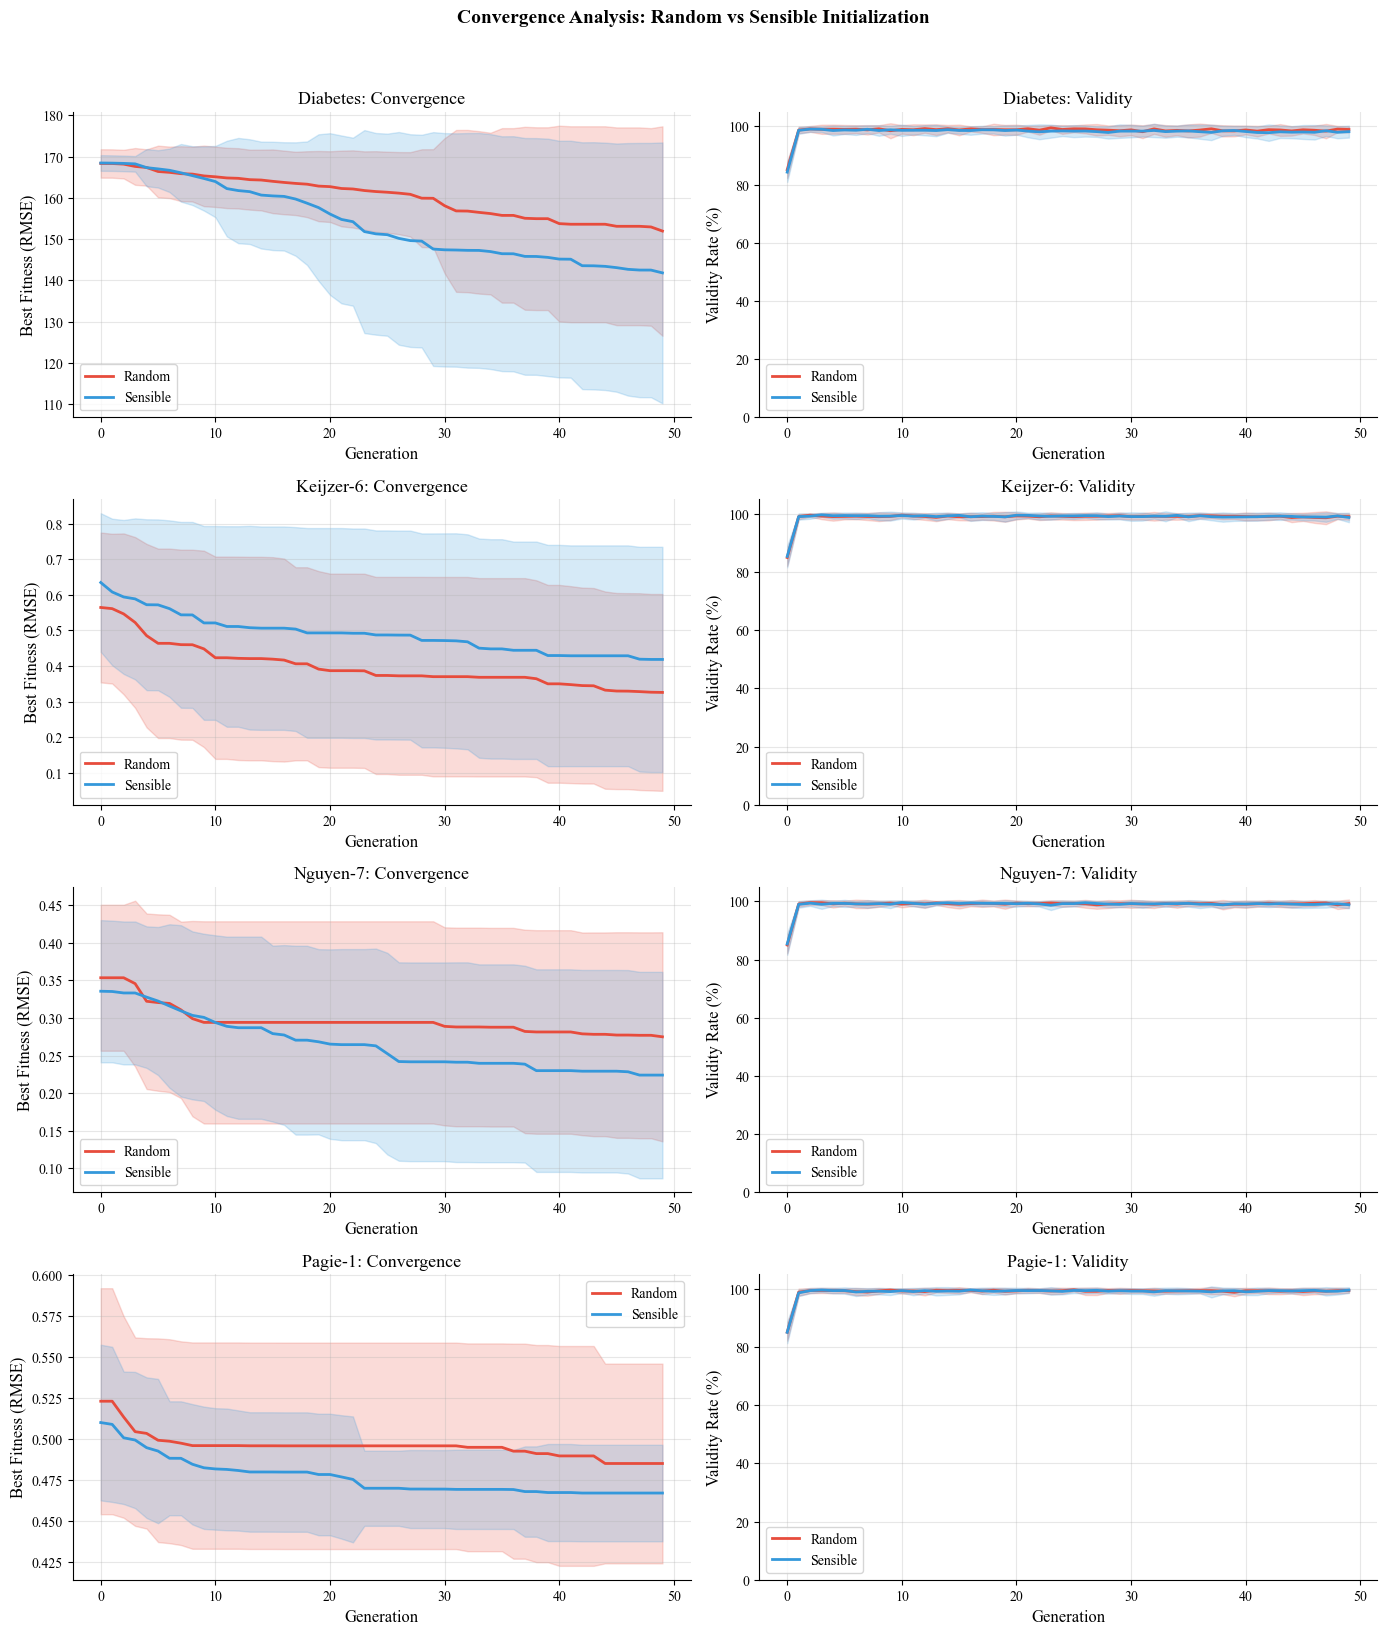

In [11]:

# %%
fig, axes = plt.subplots(len(PROBLEMS), 2, figsize=(14, 4*len(PROBLEMS)))
fig.suptitle('Convergence Analysis: Random vs Sensible Initialization', fontsize=14, fontweight='bold', y=1.02)

for row, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    generations = len(results[methods[0]][0]['history']['best_fitness'])
    
    # Best fitness
    ax = axes[row, 0]
    for m in methods:
        curves = np.array([r['history']['best_fitness'] for r in results[m]])
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        x = np.arange(generations)
        ax.plot(x, mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(x, mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Best Fitness (RMSE)')
    ax.set_title(f'{prob_name}: Convergence'); ax.legend(); ax.grid(True, alpha=0.3)
    
    # Validity
    ax = axes[row, 1]
    for m in methods:
        curves = np.array([r['history']['validity_rate'] for r in results[m]]) * 100
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        ax.plot(np.arange(generations), mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(np.arange(generations), mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Validity Rate (%)')
    ax.set_title(f'{prob_name}: Validity'); ax.legend(); ax.set_ylim([0, 105]); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_all_problems.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualization: Boxplots

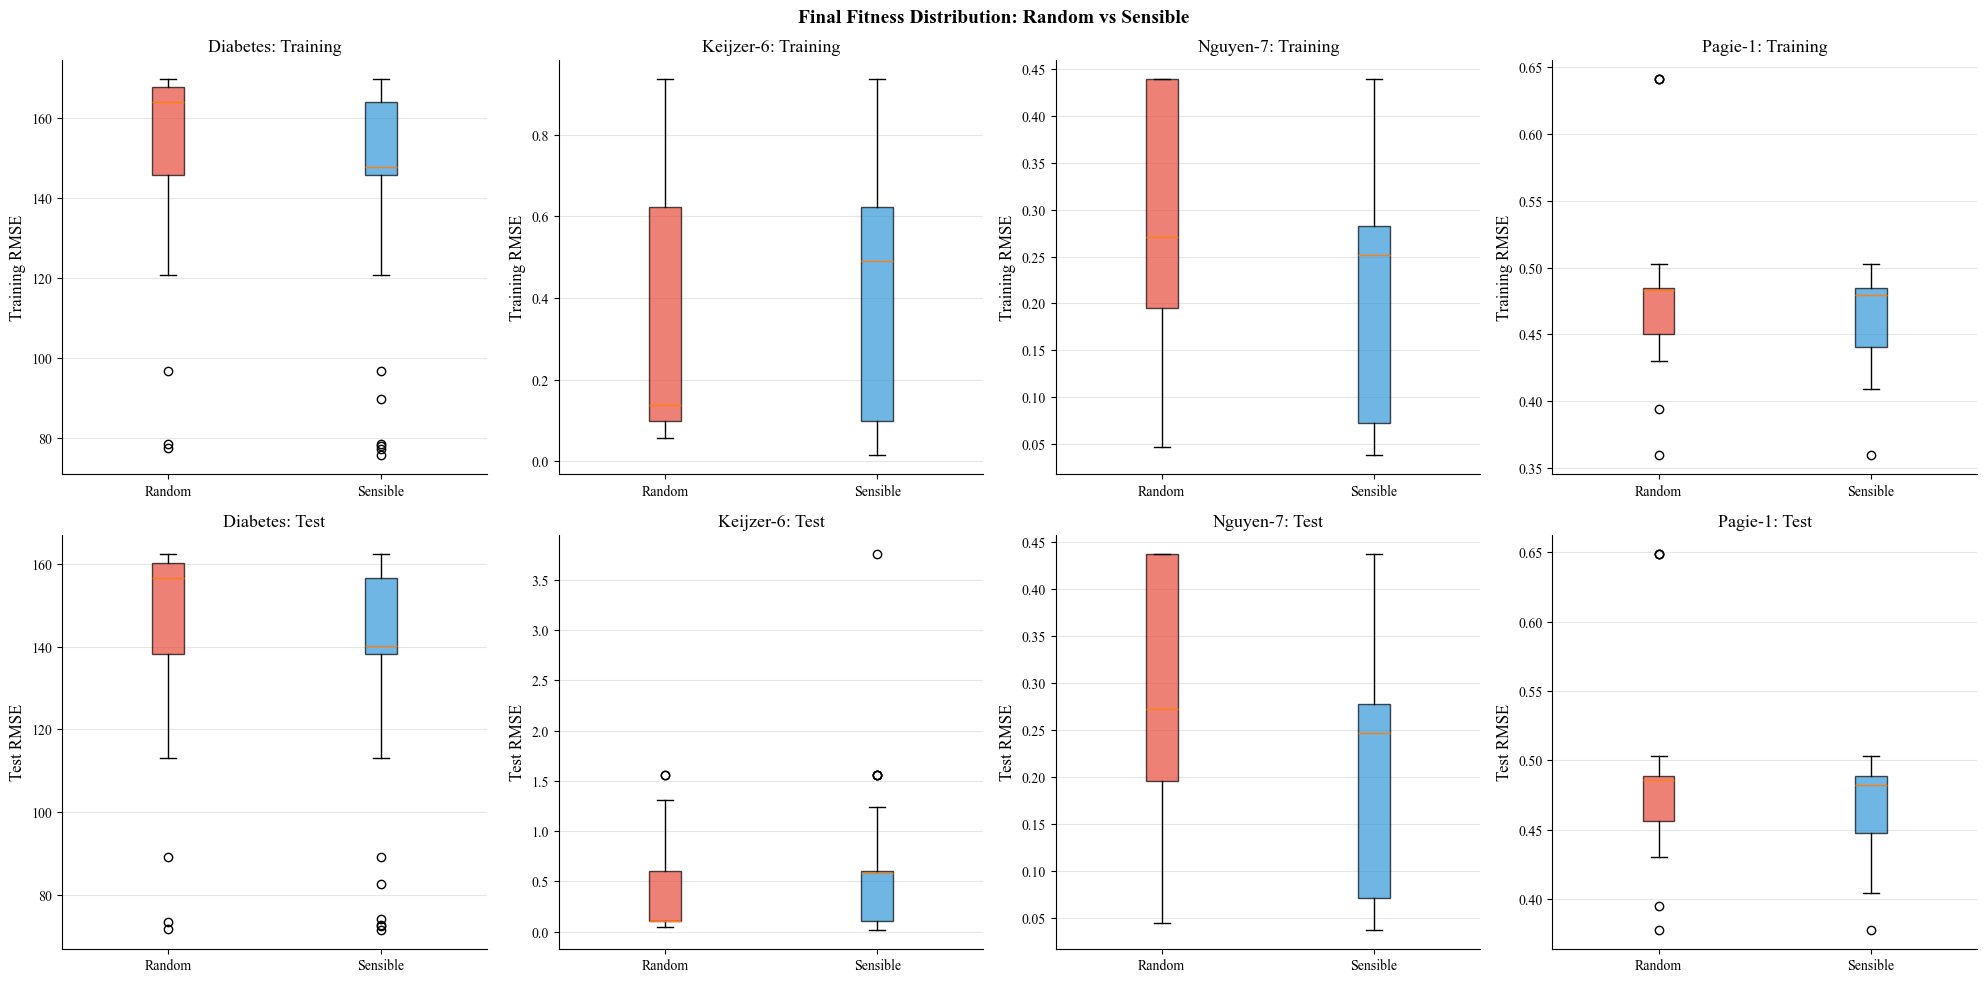

In [12]:
# %%
fig, axes = plt.subplots(2, len(PROBLEMS), figsize=(5*len(PROBLEMS), 10))
fig.suptitle('Final Fitness Distribution: Random vs Sensible', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    
    # Training
    ax = axes[0, col]
    data = [[r['best_individual'].fitness for r in results[m]] for m in methods]
    bp = ax.boxplot(data, labels=methods, patch_artist=True)
    for patch, m in zip(bp['boxes'], methods):
        patch.set_facecolor(COLORS[m]); patch.set_alpha(0.7)
    ax.set_ylabel('Training RMSE'); ax.set_title(f'{prob_name}: Training'); ax.grid(True, alpha=0.3, axis='y')
    
    # Test
    ax = axes[1, col]
    data = [[r['test_rmse'] for r in results[m]] for m in methods]
    bp = ax.boxplot(data, labels=methods, patch_artist=True)
    for patch, m in zip(bp['boxes'], methods):
        patch.set_facecolor(COLORS[m]); patch.set_alpha(0.7)
    ax.set_ylabel('Test RMSE'); ax.set_title(f'{prob_name}: Test'); ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('boxplots_all_problems.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualization: Initialization Analysis

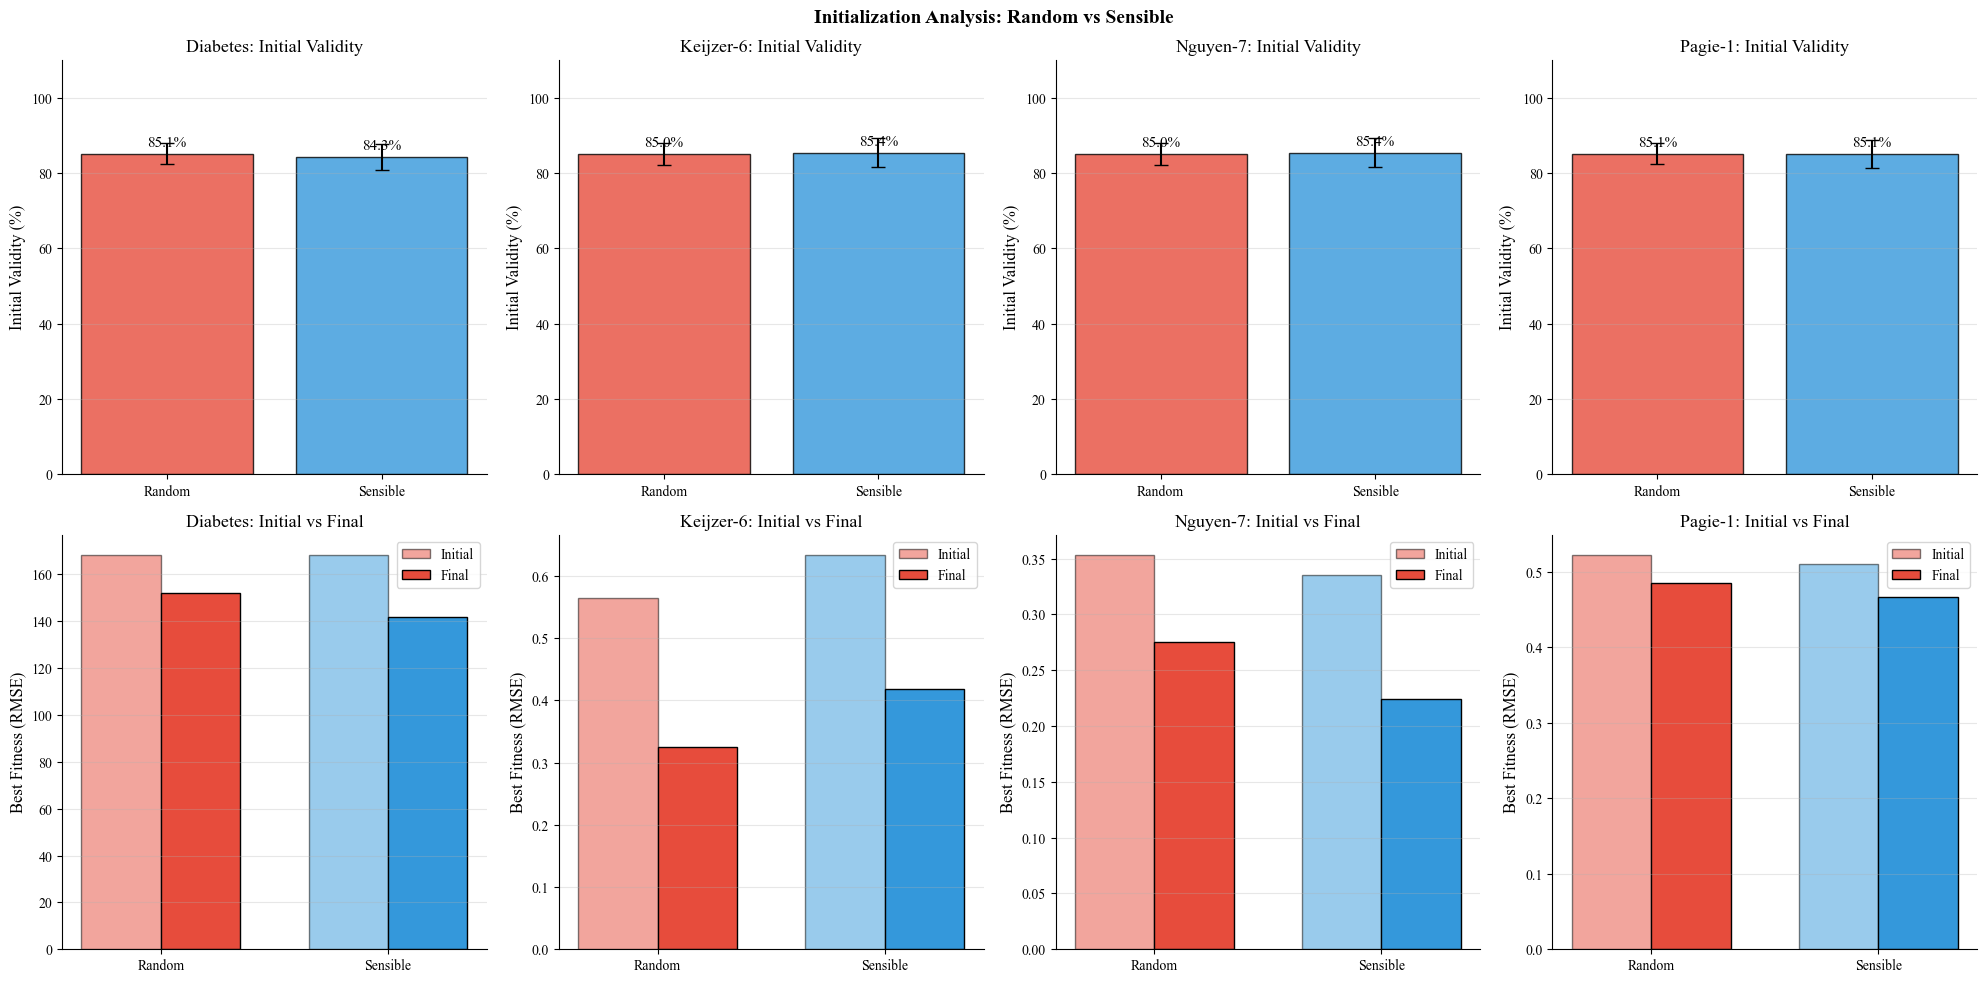

In [14]:
# %%
fig, axes = plt.subplots(2, len(PROBLEMS), figsize=(5*len(PROBLEMS), 10))
fig.suptitle('Initialization Analysis: Random vs Sensible', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    
    # Initial validity
    ax = axes[0, col]
    validity = {m: [r['history']['validity_rate'][0]*100 for r in results[m]] for m in methods}
    means = [np.mean(validity[m]) for m in methods]
    stds = [np.std(validity[m]) for m in methods]
    bars = ax.bar(methods, means, yerr=stds, capsize=5, color=[COLORS[m] for m in methods], alpha=0.8, edgecolor='black')
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{mean:.1f}%', ha='center')
    ax.set_ylabel('Initial Validity (%)'); ax.set_title(f'{prob_name}: Initial Validity')
    ax.set_ylim([0, 110]); ax.grid(True, alpha=0.3, axis='y')
    
    # Initial vs Final
    ax = axes[1, col]
    init_fit = {m: [r['history']['best_fitness'][0] for r in results[m]] for m in methods}
    final_fit = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    x = np.arange(len(methods)); width = 0.35
    ax.bar(x - width/2, [np.mean(init_fit[m]) for m in methods], width, label='Initial', 
           color=[COLORS[m] for m in methods], alpha=0.5, edgecolor='black')
    ax.bar(x + width/2, [np.mean(final_fit[m]) for m in methods], width, label='Final',
           color=[COLORS[m] for m in methods], alpha=1.0, edgecolor='black')
    ax.set_xticks(x); ax.set_xticklabels(methods)
    ax.set_ylabel('Best Fitness (RMSE)'); ax.set_title(f'{prob_name}: Initial vs Final')
    ax.legend(); ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('initialization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualization: Diversity Analysis

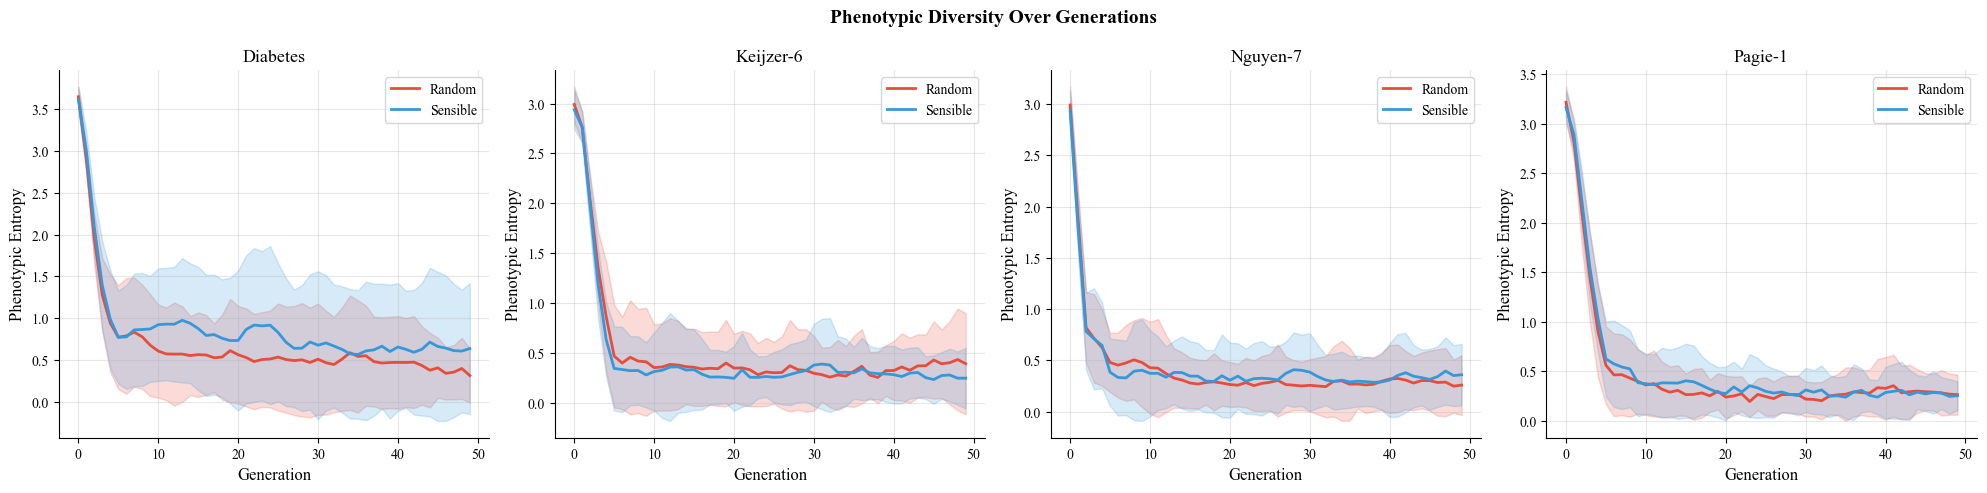

In [15]:

# %%
fig, axes = plt.subplots(1, len(PROBLEMS), figsize=(5*len(PROBLEMS), 5))
fig.suptitle('Phenotypic Diversity Over Generations', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    ax = axes[col]
    methods = list(results.keys())
    generations = len(results[methods[0]][0]['history']['diversity'])
    
    for m in methods:
        curves = np.array([r['history']['diversity'] for r in results[m]])
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        ax.plot(np.arange(generations), mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(np.arange(generations), mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Phenotypic Entropy')
    ax.set_title(f'{prob_name}'); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diversity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Summary Tables

In [16]:
# %%
print("\n" + "="*70)
print(" EXPERIMENT SUMMARY")
print("="*70)

problems = list(all_results.keys())
methods = list(all_results[problems[0]].keys())

print("\nMean Training RMSE (Std):")
print("-" * 75)
header = f"{'Method':<12}" + "".join([f"{p:>20}" for p in problems])
print(header)
print("-" * 75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        f = [r['best_individual'].fitness for r in all_results[p][m]]
        row += f"{np.mean(f):>10.2f} ({np.std(f):.2f})"
    print(row)

print("\nMean Test RMSE (Std):")
print("-" * 75)
print(header)
print("-" * 75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        f = [r['test_rmse'] for r in all_results[p][m]]
        row += f"{np.mean(f):>10.2f} ({np.std(f):.2f})"
    print(row)

print("\nInitial Validity Rate (%):")
print("-" * 75)
print(header)
print("-" * 75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        v = [r['history']['validity_rate'][0]*100 for r in all_results[p][m]]
        row += f"{np.mean(v):>10.1f} ({np.std(v):.1f})"
    print(row)


 EXPERIMENT SUMMARY

Mean Training RMSE (Std):
---------------------------------------------------------------------------
Method                  Diabetes           Keijzer-6            Nguyen-7             Pagie-1
---------------------------------------------------------------------------
Random          151.92 (25.40)      0.33 (0.28)      0.28 (0.14)      0.48 (0.06)
Sensible        141.74 (31.73)      0.42 (0.32)      0.22 (0.14)      0.47 (0.03)

Mean Test RMSE (Std):
---------------------------------------------------------------------------
Method                  Diabetes           Keijzer-6            Nguyen-7             Pagie-1
---------------------------------------------------------------------------
Random          144.54 (24.98)      0.43 (0.45)      0.27 (0.14)      0.49 (0.06)
Sensible        134.60 (30.92)      0.62 (0.77)      0.22 (0.14)      0.47 (0.03)

Initial Validity Rate (%):
---------------------------------------------------------------------------
Method 

### Best Solutions Found

In [17]:
print("\n" + "="*70)
print(" BEST SOLUTIONS FOUND")
print("="*70)

for prob_name, results in all_results.items():
    print(f"\n{'#'*60}")
    print(f"# {prob_name}")
    print(f"{'#'*60}")
    
    for method in results:
        best_run = min(results[method], key=lambda r: r['best_individual'].fitness)
        best = best_run['best_individual']
        
        pheno = best.phenotype or "N/A"
        if len(pheno) > 70:
            pheno = pheno[:70] + "..."
        
        print(f"\n  {method}:")
        print(f"    Train RMSE: {best.fitness:.6f}")
        print(f"    Test RMSE:  {best_run['test_rmse']:.6f}")
        print(f"    Phenotype:  {pheno}")

print("\n" + "="*70)
print(" EXPERIMENT COMPLETE!")
print("="*70)


 BEST SOLUTIONS FOUND

############################################################
# Diabetes
############################################################

  Random:
    Train RMSE: 77.506787
    Test RMSE:  71.857674
    Phenotype:  (3.14159*np.abs((((x8+2.71828)*2.71828)*np.abs((np.abs(3.14159)+3.1415...

  Sensible:
    Train RMSE: 75.592958
    Test RMSE:  71.395689
    Phenotype:  (3.14159*(((np.abs(2.71828)*2.71828)-((0.5*x1)+(x1-(1.0-0.5))))*np.abs...

############################################################
# Keijzer-6
############################################################

  Random:
    Train RMSE: 0.058479
    Test RMSE:  0.060736
    Phenotype:  (0.5+np.log((np.abs(x)-((np.sin(np.sqrt(x))*1.0)-2.0))))

  Sensible:
    Train RMSE: 0.014618
    Test RMSE:  0.012762
    Phenotype:  np.log(np.abs((((1.0-(x*(2.0*0.1)))+x)+x)))

############################################################
# Nguyen-7
############################################################

  Random